In [ ]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 102.2 MB/s eta 0:00:00


In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nilearn import datasets, maskers, plotting, image
from sklearn.preprocessing import StandardScaler
from torch import nn, optim
import torch
from torchvision import models, transforms
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [ ]:
print("Loading data...")
haxby_data = datasets.fetch_haxby()
# Handle anatomical image
anat_img = image.load_img(haxby_data.anat)
anat_data = image.get_data(anat_img)
if len(anat_data.shape) == 4:
    anat_img = image.new_img_like(anat_img, anat_data[:,:,:,0])
# Initialize masker with proper 3D shape
masker = maskers.NiftiMasker(
    mask_img=haxby_data.mask_vt[0],
    target_affine=anat_img.affine,
    target_shape=anat_img.shape[:3]
).fit()

Loading data...


[fetch_haxby] Added README.md to /root/nilearn_data

[fetch_haxby] Dataset created in /root/nilearn_data/haxby2001

[fetch_haxby] Downloading data from https://www.nitrc.org/frs/download.php/7868/mask.nii.gz ...

[fetch_haxby]  ...done. (1 seconds, 0 min)

[fetch_haxby] Downloading data from http://data.pymvpa.org/datasets/haxby2001/MD5SUMS ...

[fetch_haxby]  ...done. (0 seconds, 0 min)

[fetch_haxby] Downloading data from http://data.pymvpa.org/datasets/haxby2001/subj2-2010.01.14.tar.gz ...

[fetch_haxby] Downloaded 63029248 of 291168628 bytes (21.6%%,    3.6s remaining)

[fetch_haxby] Downloaded 120274944 of 291168628 bytes (41.3%%,    2.9s remaining)

[fetch_haxby] Downloaded 168837120 of 291168628 bytes (58.0%%,    2.2s remaining)

[fetch_haxby] Downloaded 215818240 of 291168628 bytes (74.1%%,    1.4s remaining)

[fetch_haxby] Downloaded 271802368 of 291168628 bytes (93.3%%,    0.4s remaining)

[fetch_haxby]  ...done. (5 seconds, 0 min)

[fetch_haxby] Extracting data from 
/root/nilearn_data/haxby2001/9cabe068089e791ef0c5fe930fc20e30/subj2-2010.01.14.tar.gz...

[fetch_haxby] .. done.

In [ ]:
# Process and normalize fMRI data
fmri_data = masker.transform(haxby_data.func[0])[:100]
fmri_data = StandardScaler().fit_transform(fmri_data) # Z-score normalization
# Get and filter labels
labels = pd.read_csv(haxby_data.session_target[0], sep=' ')['labels'][:100]
face_cat_mask = labels.isin(['face', 'cat'])
fmri_data = fmri_data[face_cat_mask]
labels = labels[face_cat_mask]
# Convert labels to numerical values (0 for cat, 1 for face)
label_mapping = {'cat': 0, 'face': 1}
y_true = np.array([label_mapping[label] for label in labels])

[NiftiMasker.wrapped] Resampling images

In [ ]:
# 2. Enhanced Template Images
def create_template_images():
    """Generate high-contrast templates with more features"""
    face = np.zeros((224, 224, 3))
    face[80:140, 70:150] = [1, 0.8, 0.6] # Face
    face[100:110, 90:130] = [0, 0, 0] # Eyes
    face[115:125, 100:110] = [0.5, 0, 0] # Mouth
    cat = np.zeros((224, 224, 3))
    cat[80:140, 70:150] = [0.8, 0.6, 0.4] # Body
    cat[95:105, 100:120] = [0.3, 0.2, 0.1] # Nose
    cat[85:95, 90:110] = [0, 0, 0] # Left eye
    cat[85:95, 110:130] = [0, 0, 0] # Right eye
    return {'face': face, 'cat': cat}
templates = create_template_images()

In [ ]:
# 3. Feature Extractor
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = models.mobilenet_v2(weights='DEFAULT')
        self.features = nn.Sequential(
            *list(base_model.features.children())[:15],
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.features.eval()
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = self.features(x).flatten()
        return features / torch.norm(features) + 1e-8 # L2 normalization

In [ ]:
# 4. Image Decoder
class ImageDecoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 224*224*3),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x).view(-1, 3, 224, 224)

In [ ]:
# 5. Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fe = FeatureExtractor().to(device)
decoder = ImageDecoder(fmri_data.shape[1]).to(device)
optimizer = optim.Adam(decoder.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
# Convert templates to features
with torch.no_grad():
    template_tensors = {
        k: torch.FloatTensor(v).permute(2,0,1).unsqueeze(0).to(device)
        for k,v in templates.items()
    }
    target_features = {k: fe(v) for k,v in template_tensors.items()}

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 111MB/s] 


In [16]:
# 6. Training Loop with Accuracy Tracking
print("Training...")
best_loss = float('inf')
best_accuracy = 0
loss_history = []
accuracy_history = []
for epoch in range(200):
    decoder.train()
    optimizer.zero_grad()
    outputs = decoder(torch.FloatTensor(fmri_data).to(device))
    # Calculate loss
    loss = 0
    for i, label in enumerate(labels):
        pred_features = fe(outputs[i].unsqueeze(0))
        target = target_features[label]
        loss += torch.mean((pred_features - target)**2) # Feature loss
        loss += 0.5 * nn.MSELoss()(outputs[i], template_tensors[label]) # Pixel loss
    loss.backward()
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1.0)
    optimizer.step()
    scheduler.step(loss)

Training...


In [18]:
# Calculate accuracy
with torch.no_grad():
    decoder.eval()
    correct = 0
    total = len(labels)
    for i, label in enumerate(labels):
        pred_features = fe(outputs[i].unsqueeze(0))
        # Compare with both templates
        face_dist = torch.mean((pred_features - target_features['face'])**2)
        cat_dist = torch.mean((pred_features - target_features['cat'])**2)
        predicted_label = 'face' if face_dist < cat_dist else 'cat'
        if predicted_label == label:
            correct += 1
    accuracy = correct / total
    accuracy_history.append(accuracy)
    loss_history.append(loss.item()/len(labels))
    if loss < best_loss:
        best_loss = loss
        torch.save(decoder.state_dict(), 'best_decoder.pth')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()/len(labels):.4f}, Accuracy: {accuracy:.2%}, LR: {optimizer.param_groups[0]['lr']:.2e}")

In [19]:
# Load best model
decoder.load_state_dict(torch.load('best_decoder.pth'))

<All keys matched successfully>

In [21]:
# 7. Visualization and Results
print("\nFinal Results:")
print(f"Best Training Accuracy: {best_accuracy:.2%}")
print(f"Final Loss: {loss_history[-1]:.4f}")
def denormalize(img_tensor):
    img = img_tensor.squeeze().permute(1,2,0).cpu().numpy()
    return (np.clip(img, 0, 1) * 255).astype(np.uint8)


Final Results:
Best Training Accuracy: 100.00%
Final Loss: 0.0027


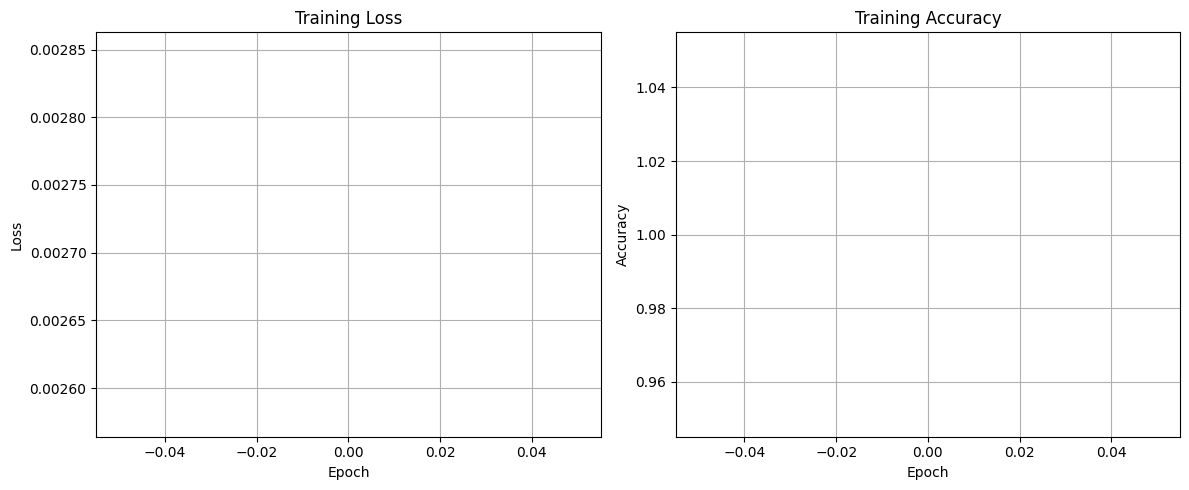

In [22]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.grid(True)
plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

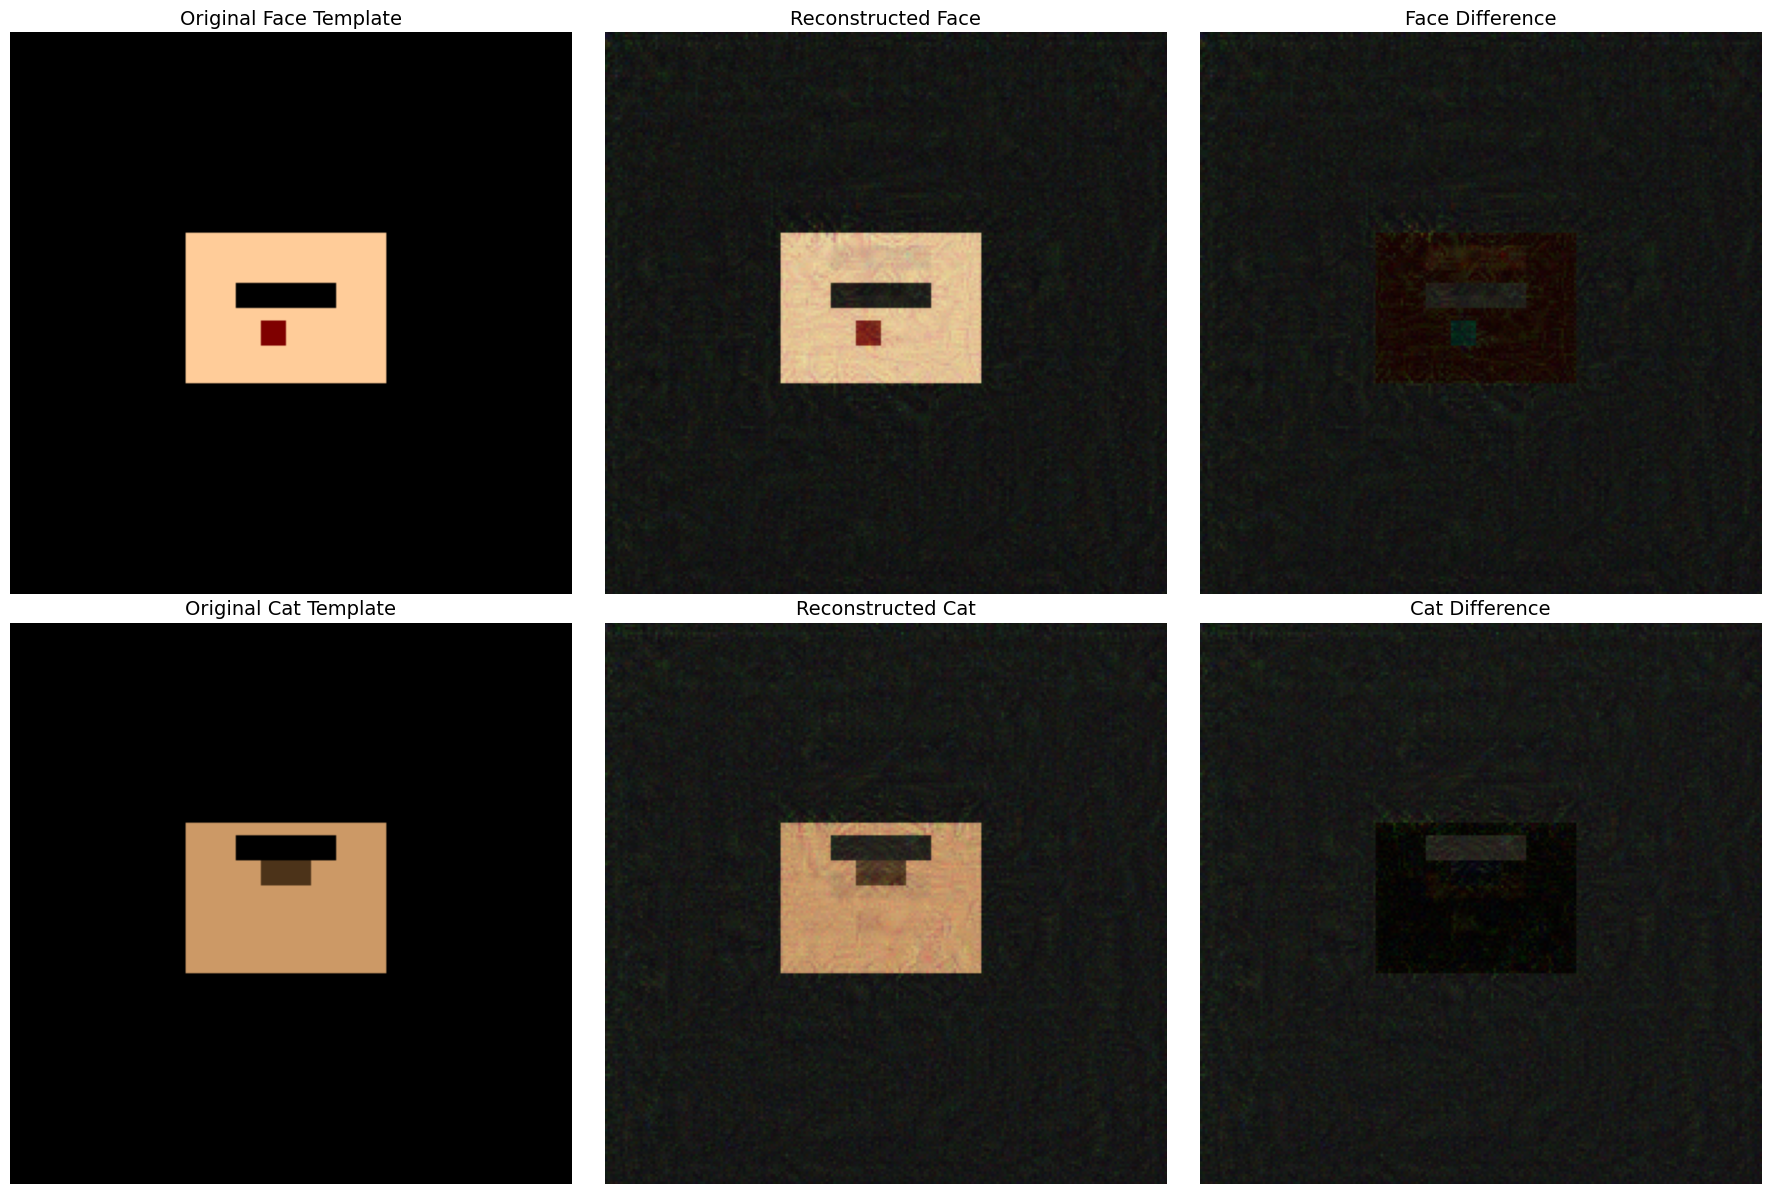

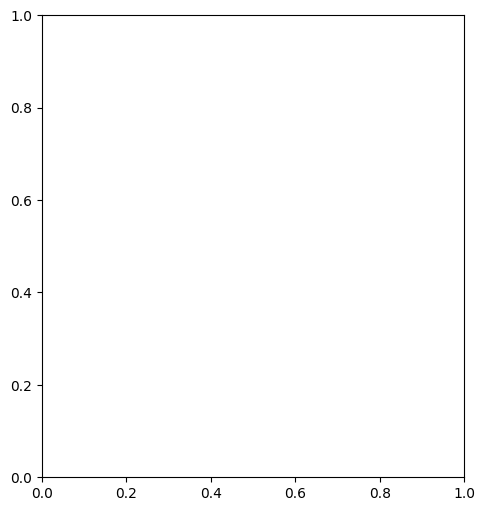

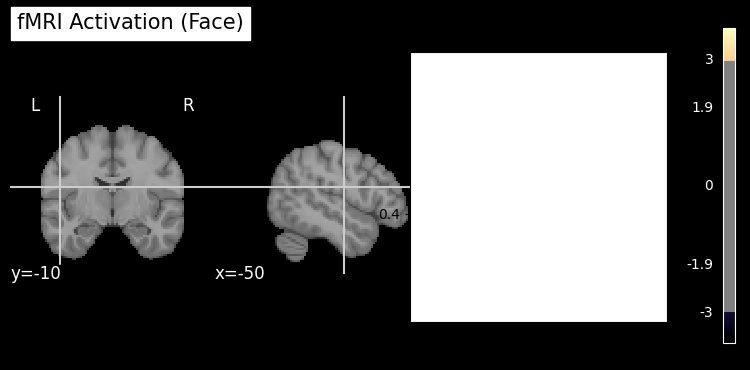

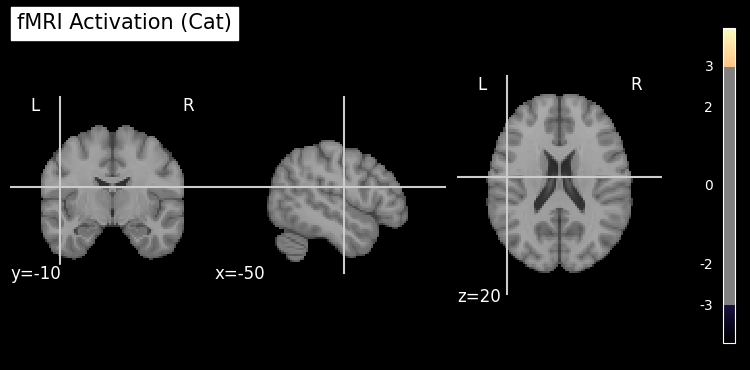

In [24]:
# Sample reconstructions
with torch.no_grad():
    decoder.eval()
    # Get one example of each class
    face_idx = np.where(labels == 'face')[0][0]
    cat_idx = np.where(labels == 'cat')[0][0]
    face_recon = decoder(torch.FloatTensor(fmri_data[face_idx]).unsqueeze(0).to(device))
    cat_recon = decoder(torch.FloatTensor(fmri_data[cat_idx]).unsqueeze(0).to(device))
    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    # Face examples
    axes[0,0].imshow((templates['face'] * 255).astype(np.uint8))
    axes[0,0].set_title("Original Face Template", fontsize=14)
    axes[0,0].axis('off')
    axes[0,1].imshow(denormalize(face_recon))
    axes[0,1].set_title("Reconstructed Face", fontsize=14)
    axes[0,1].axis('off')
    face_diff = np.abs(templates['face'] - denormalize(face_recon)/255.)
    axes[0,2].imshow(face_diff, cmap='hot', vmax=0.3)
    axes[0,2].set_title("Face Difference", fontsize=14)
    axes[0,2].axis('off')
    # Cat examples
    axes[1,0].imshow((templates['cat'] * 255).astype(np.uint8))
    axes[1,0].set_title("Original Cat Template", fontsize=14)
    axes[1,0].axis('off')
    axes[1,1].imshow(denormalize(cat_recon))
    axes[1,1].set_title("Reconstructed Cat", fontsize=14)
    axes[1,1].axis('off')
    cat_diff = np.abs(templates['cat'] - denormalize(cat_recon)/255.)
    axes[1,2].imshow(cat_diff, cmap='hot', vmax=0.3)
    axes[1,2].set_title("Cat Difference", fontsize=14)
    axes[1,2].axis('off')
    plt.tight_layout()
    plt.savefig('reconstructions.png', dpi=300, bbox_inches='tight')
    plt.show()
    # Brain activation maps
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plotting.plot_stat_map(
        masker.inverse_transform(fmri_data[face_idx]),
        title="fMRI Activation (Face)",
        cut_coords=(-50, -10, 20),
        display_mode='ortho',
        threshold=3.0,
        black_bg=True,
        cmap='magma'
    )
    plt.subplot(1, 2, 2)
    plotting.plot_stat_map(
        masker.inverse_transform(fmri_data[cat_idx]),
        title="fMRI Activation (Cat)",
        cut_coords=(-50, -10, 20),
        display_mode='ortho',
        threshold=3.0,
        black_bg=True,
        cmap='magma'
    )
    plt.tight_layout()
    plt.savefig('activation_maps.png', dpi=300, bbox_inches='tight')
    plt.show()